In [1]:
import pandas as pd
import numpy  as np
from nilearn import image,plotting
from scipy import stats
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import pickle

In [2]:
import TransBrain as TB

## Autism Structural Deviation

### load deviation pattern

In [3]:
human_deviation_pattern = pd.read_csv('z_autism_regress.csv') # Deviant patterns in autistic individuals

In [4]:
human_deviation_pattern.set_index('Unnamed: 0',inplace=True,drop=True)

In [5]:
mouse_mutation_pattern = pd.read_csv('mouse_mutation_pattern.csv') # Deviant patterns in autism mouse models

In [6]:
mouse_mutation_pattern.set_index('Unnamed: 0',inplace=True,drop=True)

### translating mouse mutation patterns to human

In [7]:
Transformer = TB.trans.SpeciesTrans()

INFO:root:SpeciesTrans initialized
INFO:root:Loading graph embeddings.


In [8]:
help(Transformer.mouse_to_human)

Help on method mouse_to_human in module TransBrain.trans:

mouse_to_human(mouse_phenotype, region_type='cortex', normalize_input=True, restore_output=False) method of TransBrain.trans.SpeciesTrans instance
    Translate mouse phenotype to human phenotype.
    
    Parameters:
    
        mouse_phenotype (pandas.DataFrame): DataFrame containing mouse phenotype data.
        
        index|phenotype1|phenotype2|...
        
        region_type (str): Type of regions to trans. Options: 'cortex', 'subcortex', 'all'. Default is 'cortex'.
        normalize_input (bool): Whether to apply normalization to the input data. Default is False.
        restore_output (bool): Whether to restore the output predictions to the original scale. Default is False.
    
    Returns:
        pandas.DataFrame: DataFrame containing human phenotype predictions.



In [9]:
mutation_trans_in_human = Transformer.mouse_to_human(mouse_mutation_pattern,region_type='all')

INFO:root:Mouse all phenotypes have been successfully transformed to human!


### individual gene risk scores based on mouse model

In [10]:
cross_species_autism_dataframe = pd.DataFrame()

for i in range(human_deviation_pattern.shape[0]):
    
    row_data = human_deviation_pattern.iloc[i].values
    corr_l = []
    
    for j in range(5):

        m_data = mutation_trans_in_human.iloc[:,j].values
        corr_ = stats.pearsonr(row_data,m_data)[0]
        corr_l.append(corr_)

    cross_species_autism_dataframe[i] = corr_l

cross_species_autism_dataframe = cross_species_autism_dataframe.T
cross_species_autism_dataframe.index = human_deviation_pattern.index
cross_species_autism_dataframe.columns = mutation_trans_in_human.columns.values

### load AHBA gene expression

In [11]:
AHBA_ex = pd.read_csv('AHBA_expression.csv') # AHBA expression in region level

In [12]:
AHBA_ex.set_index('gene_symbol',inplace=True,drop=True)

### individual gene risk scores based on AHBA

In [13]:
AHBA_autism_dataframe = pd.DataFrame()

for i in range(human_deviation_pattern.shape[0]):
    
    row_data = human_deviation_pattern.iloc[i].values
    corr_l = []
    
    for j in range(5):

        m_data = AHBA_ex.iloc[j].values
        corr_ = stats.pearsonr(row_data,m_data)[0]
        corr_l.append(corr_)

    AHBA_autism_dataframe[i] = corr_l

AHBA_autism_dataframe = AHBA_autism_dataframe.T
AHBA_autism_dataframe.index = human_deviation_pattern.index
AHBA_autism_dataframe.columns = mutation_trans_in_human.columns.values

### correlate risk scores

In [14]:
stats.pearsonr(AHBA_autism_dataframe.values.flatten(),cross_species_autism_dataframe.values.flatten())

PearsonRResult(statistic=0.1978059999649528, pvalue=9.645342333400538e-12)

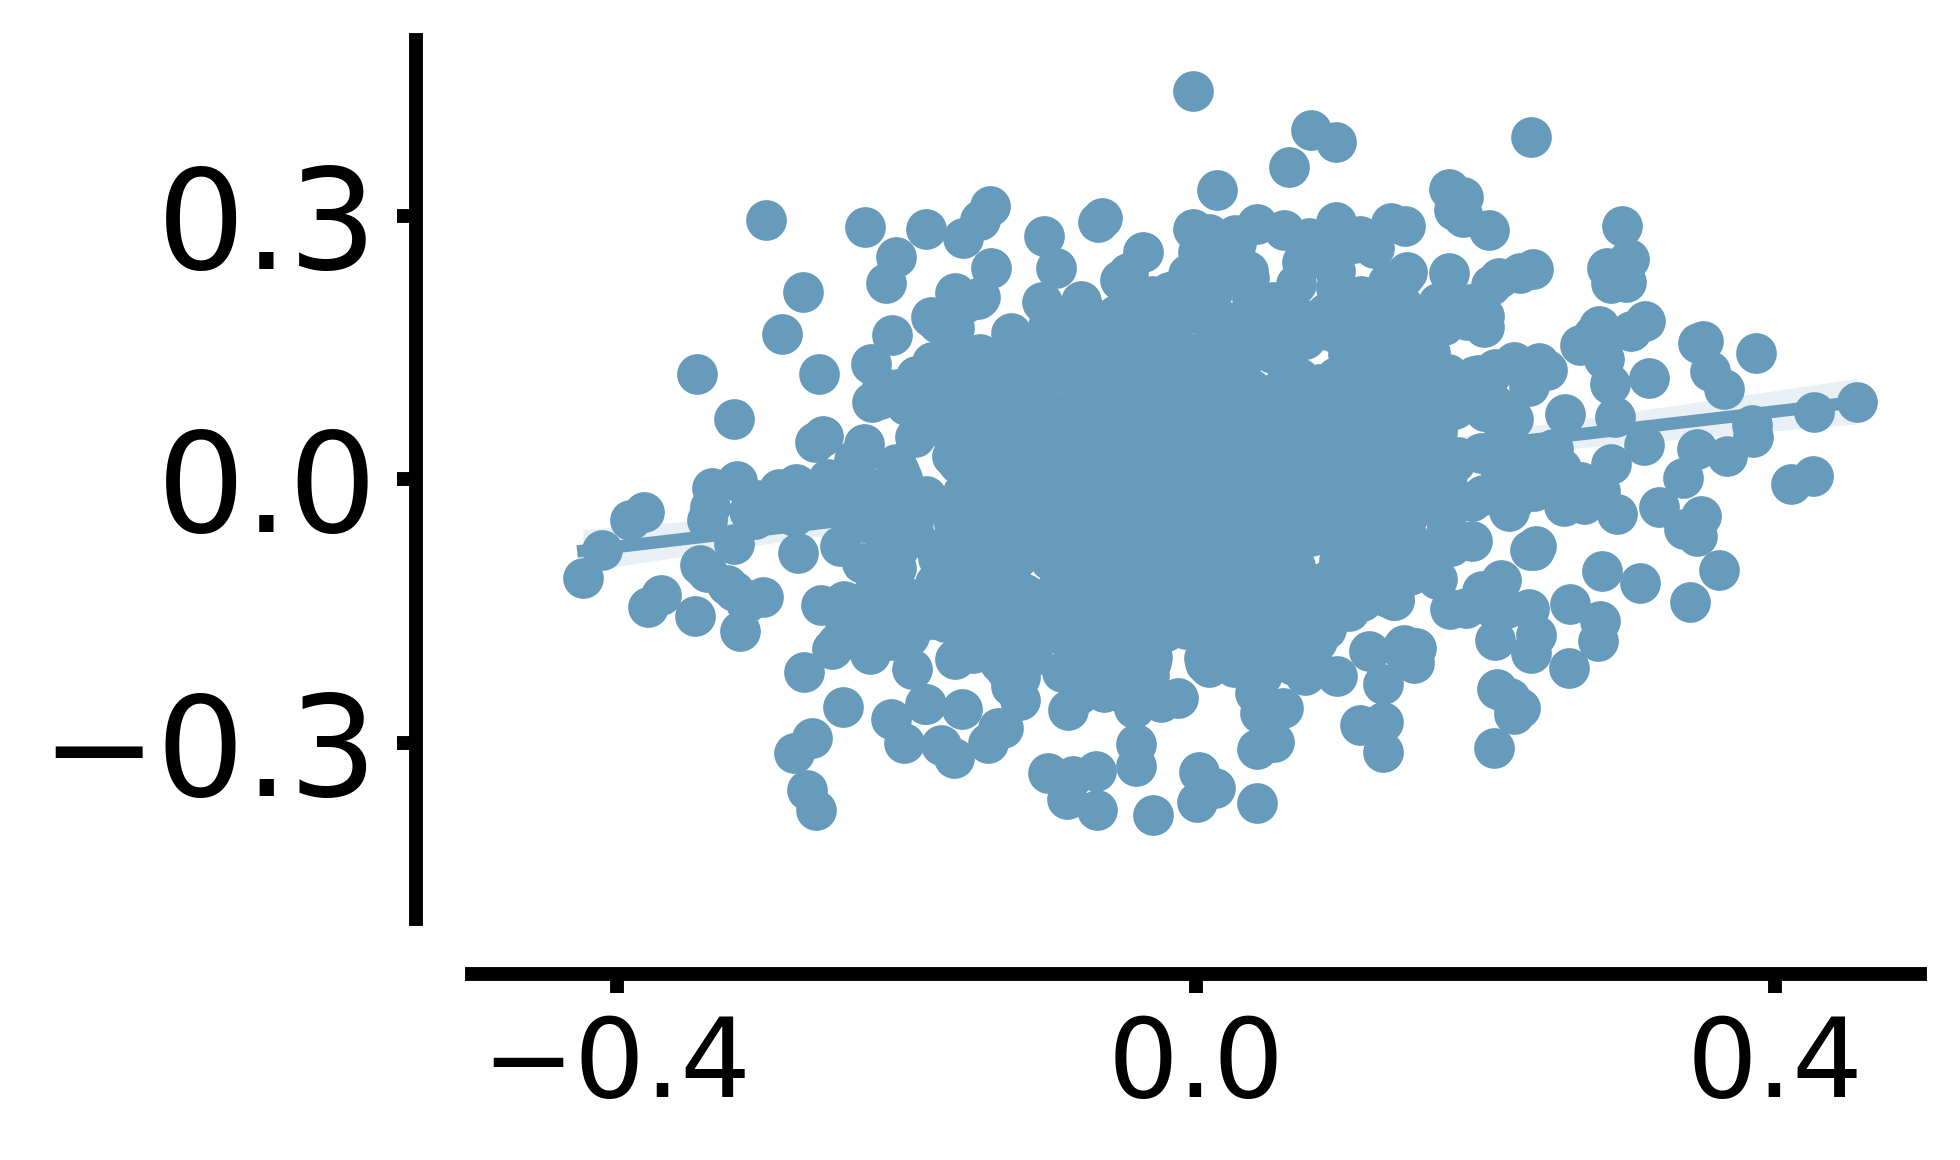

In [15]:
fig,ax=plt.subplots(1,1,figsize=(5,3),dpi=400)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelsize=15)

for spine in ax.spines.values():
    spine.set_position(('outward', 10))
    
ax.set_ylim(-0.5,0.5)
ax.set_yticks([-0.3,0.0,0.3])

ax.set_xlim(-0.5, 0.5)
ax.set_xticks([-0.4,0.0,0.4])

ax.spines['left'].set_linewidth(2.5) 
ax.spines['bottom'].set_linewidth(2.5) 
ax.tick_params(axis='x', labelsize=20, width=2.5)
ax.tick_params(axis='y', labelsize=25, width=2.5)

sns.regplot(x=AHBA_autism_dataframe.values.flatten(),y=cross_species_autism_dataframe.values.flatten(),color='#669bbc', scatter_kws={'color': '#669bbc', 'edgecolor': '#669bbc', 'linewidths': 1,'alpha':1,'s':40})
plt.tight_layout()

### correlate risk scores in specific gene

In [16]:
dict_gene_ = {}
for gene in ['Dvl1','Magel2','Slc6a4','Sgsh','Shank3--']:
    
    AHBA_scores = AHBA_autism_dataframe[gene].values
    mouse_mutation_scores = cross_species_autism_dataframe[gene].values
    r,p = stats.pearsonr(AHBA_scores,mouse_mutation_scores)
    
    dict_gene_[gene] = (r,p)

In [17]:
dict_gene_

{'Dvl1': (0.31097966299832996, 1.2856342421455486e-06),
 'Magel2': (0.4539929971213872, 3.0064151593370794e-13),
 'Slc6a4': (0.015197117448081152, 0.8175170464931003),
 'Sgsh': (0.002248242177818733, 0.9727707705317751),
 'Shank3--': (0.20016237908524437, 0.0021402800433741828)}

### correlating sythetic mutation pattern with AHBA gene expression

In [18]:
dict_gene_ = {}
for gene1,gene2 in zip(['DVL1','MAGEL2','SLC6A4','SGSH','SHANK3'],['Dvl1','Magel2','Slc6a4','Sgsh','Shank3--']):
    r,p = stats.pearsonr(AHBA_ex.T[gene1].values,mutation_trans_in_human[gene2].values)
    dict_gene_[gene1] = (r,p)

In [19]:
dict_gene_

{'DVL1': (0.09730098359735116, 0.2764762751949792),
 'MAGEL2': (0.3526186809312027, 4.78449085894465e-05),
 'SLC6A4': (-0.062062969713091, 0.4882044955368892),
 'SGSH': (0.04501704457506567, 0.6152770360499245),
 'SHANK3': (-0.06759348765582843, 0.4502055153591825)}

In [20]:
dict_gene_ = {}
for gene1,gene2 in zip(['DVL1','MAGEL2','SLC6A4','SGSH','SHANK3'],['Dvl1','Magel2','Slc6a4','Sgsh','Shank3--']):
    r,p = stats.pearsonr(AHBA_ex.T[gene1].values[:105],mutation_trans_in_human[gene2].values[:105])
    dict_gene_[gene1] = (r,p)

In [21]:
dict_gene_

{'DVL1': (0.09163004800347654, 0.3525539964385296),
 'MAGEL2': (0.5926688876223711, 2.7295029485344274e-11),
 'SLC6A4': (-0.00857379343563415, 0.9308263894863134),
 'SGSH': (0.14000334182711954, 0.15431322372547077),
 'SHANK3': (0.09513931972764555, 0.33433944229094187)}

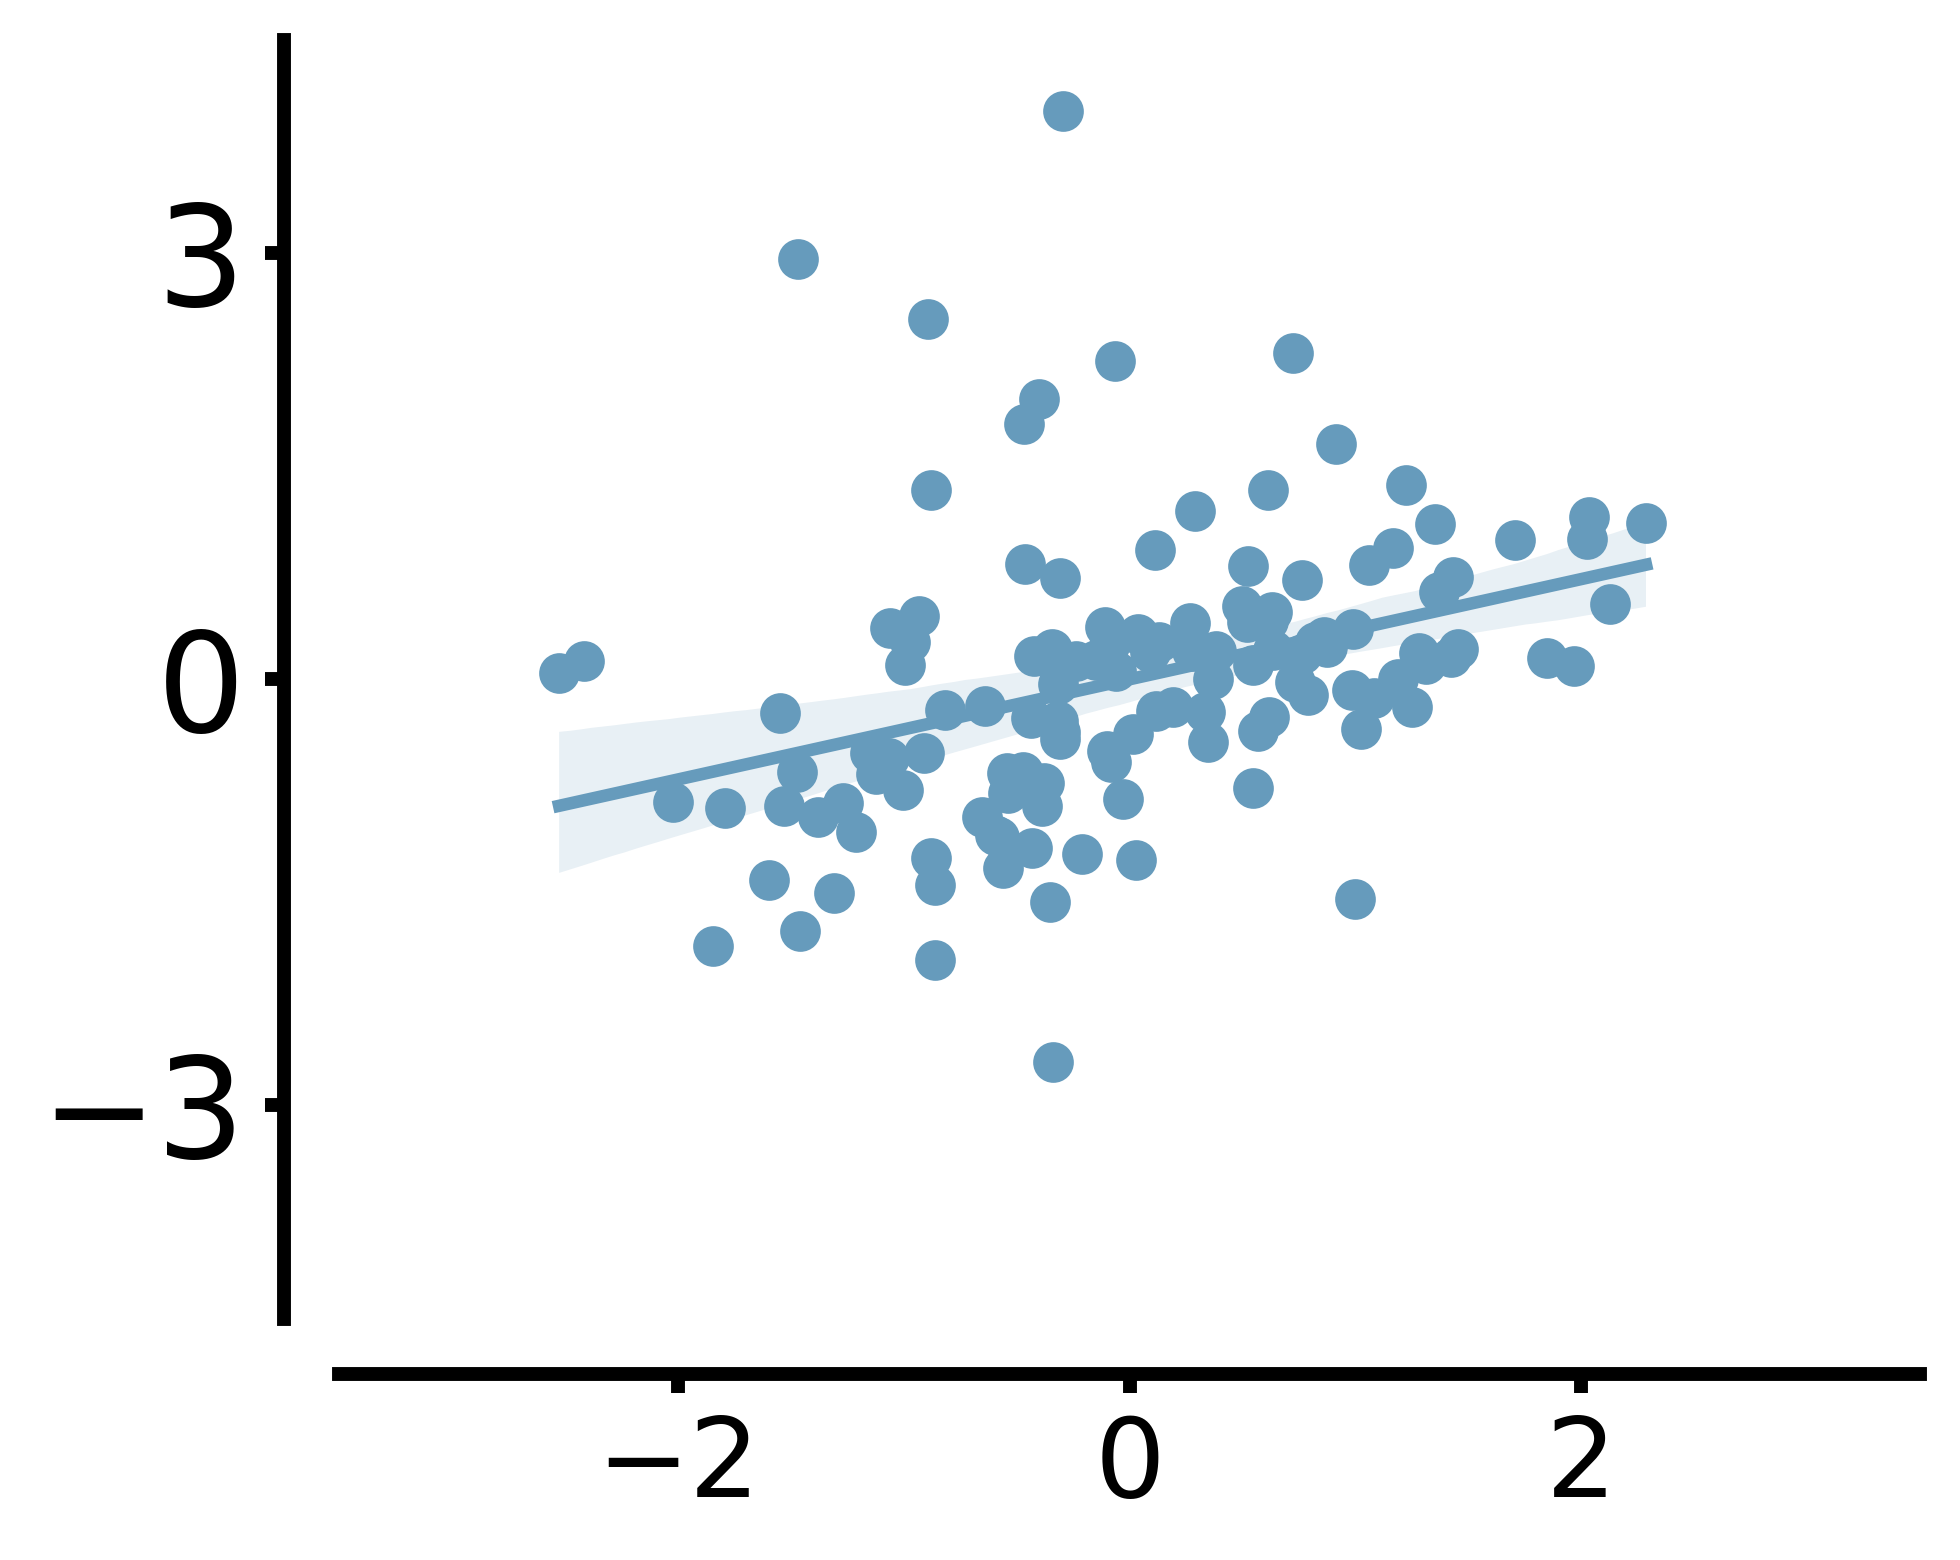

In [22]:
fig,ax=plt.subplots(1,1,figsize=(5,4),dpi=400)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelsize=15)

for spine in ax.spines.values():
    spine.set_position(('outward', 10))
    
ax.set_ylim(-4.5,4.5)
ax.set_yticks([-3,0,3])

ax.set_xlim(-3.5, 3.5)
ax.set_xticks([-2,0,2])

ax.spines['left'].set_linewidth(2.5) 
ax.spines['bottom'].set_linewidth(2.5) 
ax.tick_params(axis='x', labelsize=20, width=2.5)
ax.tick_params(axis='y', labelsize=25, width=2.5)

sns.regplot(x=stats.zscore(mutation_trans_in_human['Magel2'].values.flatten()),y=stats.zscore(AHBA_ex.T['MAGEL2'].values.flatten()),color='#669bbc', scatter_kws={'color': '#669bbc', 'edgecolor': '#669bbc', 'linewidths': 1,'alpha':1,'s':40})
plt.tight_layout()

### load behavior data

In [23]:
autism_meta = pd.read_csv('meta_info_ABIDE.csv')
autism_meta['SUB_ID'] = ['sub-00{}'.format(i) for i in autism_meta['SUB_ID'].values]
autism_meta.set_index('SUB_ID',inplace=True,drop=True)
autism_info = human_deviation_pattern.index.values
autism_meta = autism_meta.T[autism_info].T

In [24]:
behavior_l = ['FIQ','VIQ','PIQ','ADOS_COMM','ADOS_SOCIAL','ADOS_STEREO_BEHAV']

In [25]:
autism_meta = autism_meta[behavior_l]

In [26]:
autism_meta

,FIQ,VIQ,PIQ,ADOS_COMM,ADOS_SOCIAL,ADOS_STEREO_BEHAV
SUB_ID,,,,,,
sub-0050952,134.0,139.0,120.0,7.0,10.0,4.0
sub-0050953,132.0,139.0,117.0,3.0,10.0,3.0
sub-0050954,78.0,79.0,80.0,3.0,8.0,4.0
sub-0050955,93.0,96.0,91.0,3.0,11.0,3.0
sub-0050956,115.0,115.0,110.0,2.0,8.0,5.0
...,...,...,...,...,...,...
sub-0050528,100.0,90.0,109.0,5.0,7.0,1.0
sub-0050529,128.0,122.0,127.0,4.0,9.0,1.0
sub-0050530,106.0,120.0,91.0,3.0,10.0,0.0


In [27]:
magel2_scores_based_on_mouse = cross_species_autism_dataframe['Magel2'].values

In [28]:
gene_behavior_l = []
gene_clinic_dataframe = pd.DataFrame()

for name_ in autism_meta.columns.values:
    
    behavior_pattern = autism_meta[name_].values
    
    behavior_pattern = np.array([float(x) if str(x).replace('.', '', 1).isdigit() else np.nan for x in behavior_pattern])
    mask = ~np.isnan(behavior_pattern) & (behavior_pattern!=-9999.0)
    
    arr1_filtered = magel2_scores_based_on_mouse[mask]
    arr2_filtered = behavior_pattern[mask]
    
    corr = stats.pearsonr(arr1_filtered,arr2_filtered)
    
    gene_behavior_l.append(corr)
    
gene_clinic_dataframe['magel2'] = gene_behavior_l

In [29]:
gene_clinic_dataframe

,magel2
0,"(-0.17657536932333695, 0.00701340405507845)"
1,"(-0.07795466860082739, 0.2358864146002949)"
2,"(-0.18717492106148584, 0.004224509163950006)"
3,"(-0.08570567055260465, 0.25533156937957996)"
4,"(0.0025750174236128832, 0.9727870157319674)"
5,"(-0.01877159761927611, 0.8046910213502325)"


In [30]:
behavior_pattern = autism_meta['FIQ'].values
behavior_pattern = np.array([float(x) if str(x).replace('.', '', 1).isdigit() else np.nan for x in behavior_pattern])
mask = ~np.isnan(behavior_pattern) & (behavior_pattern!=-9999.0)

In [31]:
arr1_filtered = magel2_scores_based_on_mouse[mask]
arr2_filtered = behavior_pattern[mask]

In [32]:
stats.pearsonr(arr1_filtered,arr2_filtered)

PearsonRResult(statistic=-0.17657536932333695, pvalue=0.00701340405507845)

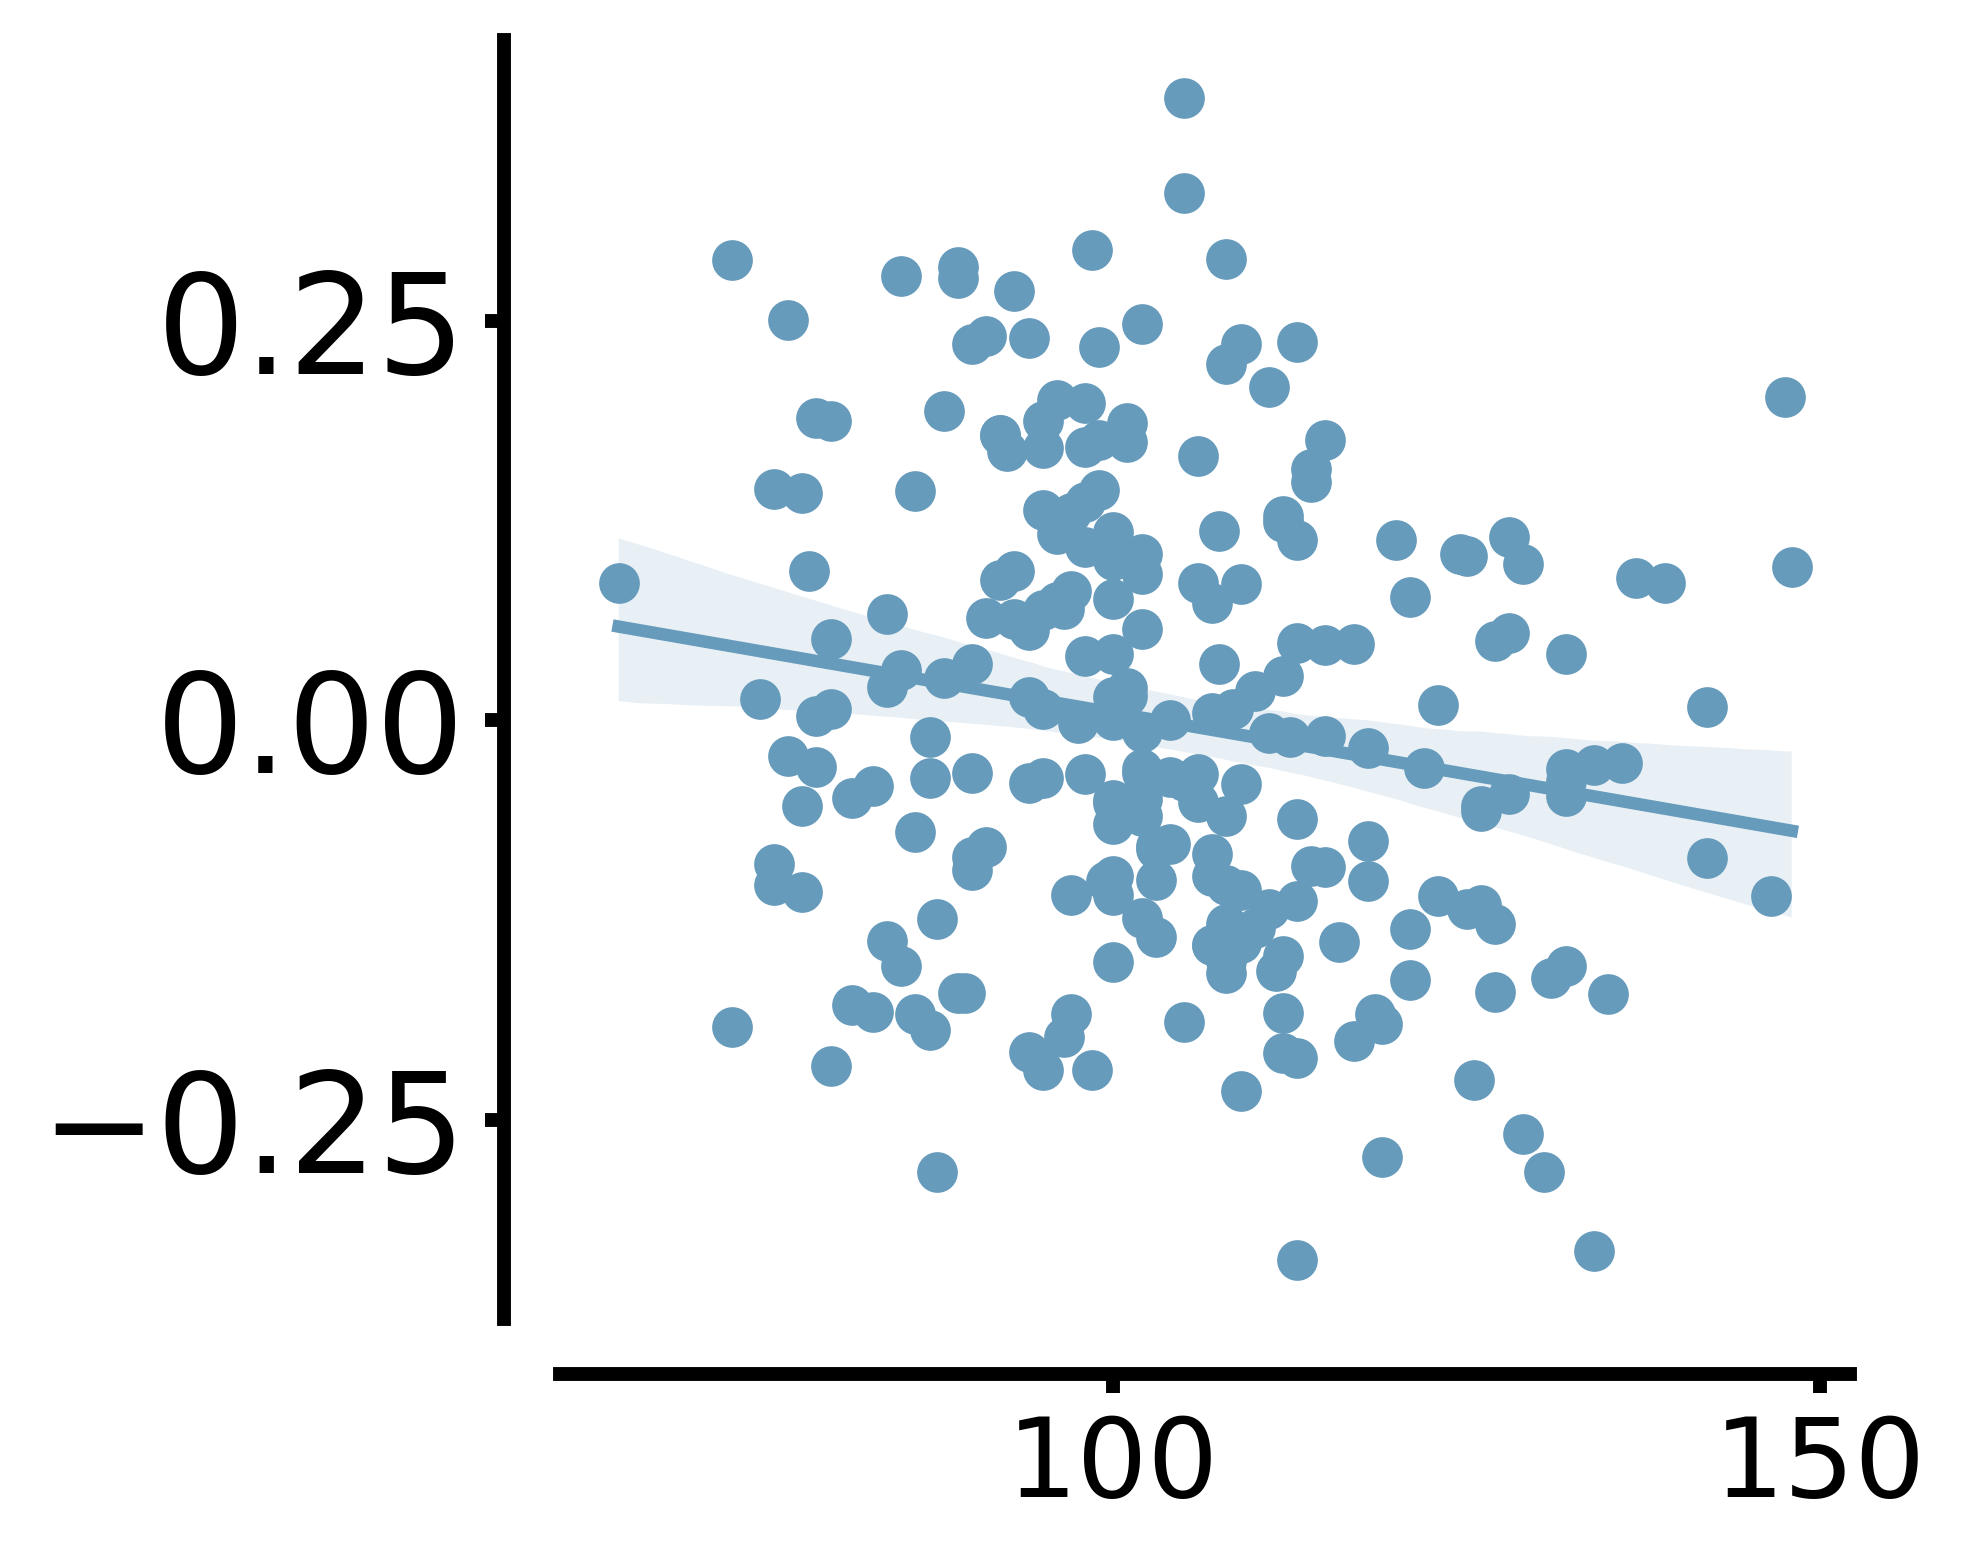

In [33]:
fig,ax=plt.subplots(1,1,figsize=(5,4),dpi=400)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelsize=15)

for spine in ax.spines.values():
    spine.set_position(('outward', 10))
    
ax.spines['left'].set_linewidth(2.5) 
ax.spines['bottom'].set_linewidth(2.5) 
ax.tick_params(axis='x', labelsize=20, width=2.5)
ax.tick_params(axis='y', labelsize=25, width=2.5)

sns.regplot(x=arr2_filtered,y=arr1_filtered,color='#669bbc', scatter_kws={'color': '#669bbc', 'edgecolor': '#669bbc', 'linewidths': 1,'alpha':1,'s':40})
plt.tight_layout()